In [1]:
import torch
from torch import nn

y1 = torch.tensor([0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0])
y2 = torch.tensor([0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0])
t = torch.tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

mse = nn.MSELoss()
print(mse(y1, t))
print(mse(y2, t))

tensor(0.0195)
tensor(0.1195)


In [2]:
loss = nn.CrossEntropyLoss()
label = torch.argmax(t, dim=0)
print(label)
print(loss(y1, label))
print(loss(y2, label))

tensor(2)
tensor(1.8195)
tensor(2.3195)


In [3]:
def f():
    return (x[0]**2 + x[1]**2)

In [4]:
def numerical_gradient(func, params, epsilon=1e-4):
    grads = []
    for param in params:
        grad = torch.zeros_like(param)
        
        param_flat = param.flatten()
        grad_flat = grad.flatten()

        for i in range(param_flat.numel()):
            original_value = param_flat[i].item()

            param_flat[i] = original_value + epsilon
            loss1 = func()

            param_flat[i] = original_value - epsilon
            loss2 = func()

            grad_flat[i] = (loss1 - loss2) / (2 * epsilon)
            param_flat[i] = original_value

        grads.append(grad)
    return grads

In [5]:
x = torch.tensor([3.0, 4.0], requires_grad=False)
grads = numerical_gradient(f, [x])
print("x:", x)
print("Numerical gradient:", grads[0])

x: tensor([3., 4.])
Numerical gradient: tensor([5.9891, 8.0013])


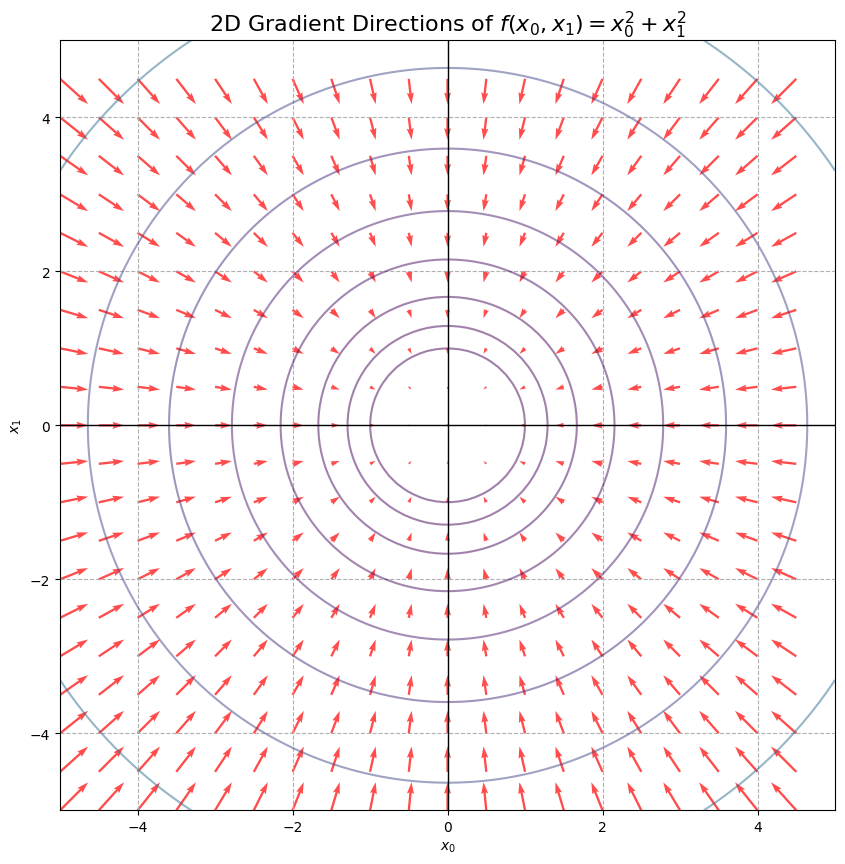

In [43]:
import matplotlib.pyplot as plt
import numpy as np

x = torch.tensor([0.0, 0.0], requires_grad=False) 
x0_range = np.arange(-5, 5, 0.5) 
x1_range = np.arange(-5, 5, 0.5) 

X0_coords = []
X1_coords = []
U_grads = [] 
V_grads = [] 

for x0_val in x0_range:
    for x1_val in x1_range:
        x[0] = x0_val
        x[1] = x1_val
        grads = numerical_gradient(f, [x])
        grad_x0 = -grads[0][0].item()
        grad_x1 = -grads[0][1].item()
        X0_coords.append(x0_val)
        X1_coords.append(x1_val)
        U_grads.append(grad_x0)
        V_grads.append(grad_x1)


plt.figure(figsize=(10, 10))
plt.quiver(X0_coords, X1_coords, U_grads, V_grads, color='red', alpha=0.7, linewidth=0.5)
X, Y = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
Z = X**2 + Y**2 
plt.contour(X, Y, Z, levels=np.logspace(0, 2, 10), cmap='viridis', alpha=0.5)
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.title('2D Gradient Directions of $f(x_0, x_1) = x_0^2 + x_1^2$', fontsize=16)
plt.grid(True, linestyle='--')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.show()

In [30]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np

iris = load_iris()
X = iris.data
y = iris.target

indices_0_1 = np.where((y == 0) | (y == 1))[0]
data = X[indices_0_1]
label = y[indices_0_1]

print(data.shape)
print(label.shape)

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
print(X_train.shape)
print(y_train.shape)

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
print(X_test.shape)
print(y_test.shape)

(100, 4)
(100,)
(80, 4)
(20, 4)
(80,)
(20,)
torch.Size([80, 4])
torch.Size([80])
torch.Size([20, 4])
torch.Size([20])


In [31]:
torch.manual_seed(42)

def init_params():
    W1 = torch.randn(5, 4, dtype=torch.float32, requires_grad=False) * 0.1
    b1 = torch.randn(5, dtype=torch.float32, requires_grad=False) * 0.1
    W2 = torch.randn(5, 5, dtype=torch.float32, requires_grad=False) * 0.1
    b2 = torch.randn(5, dtype=torch.float32, requires_grad=False) * 0.1
    W3 = torch.randn(1, 5, dtype=torch.float32, requires_grad=False) * 0.1
    b3 = torch.randn(1, dtype=torch.float32, requires_grad=False) * 0.1
    return [W1, b1, W2, b2, W3, b3]

In [33]:
def forward(x, params):
    W1, b1, W2, b2, W3, b3 = params
    z1 = W1 @ x + b1           
    a1 = torch.sigmoid(z1)     
    z2 = W2 @ a1 + b2          
    a2 = torch.sigmoid(z2)     
    z3 = W3 @ a2 + b3          
    y_pred = torch.sigmoid(z3)
    return y_pred.squeeze()

In [34]:
def update_params(params, grads, lr=0.1):
    for p, g in zip(params, grads):
        p -= lr * g

In [35]:
import torch.nn.functional as F

def train(x_all, y_all, epochs=100, lr=0.1, loss_values=None):
    params = init_params()
    N = x_all.shape[0]
    for epoch in range(epochs):
        total_loss = 0.0
        for i in range(N):
            x = x_all[i]
            y_true = y_all[i]

            loss_fn = lambda: F.binary_cross_entropy(forward(x, params), y_true)
            loss = loss_fn()
            total_loss += loss.item()

            grads = numerical_gradient(loss_fn, params)
            update_params(params, grads, lr)

        avg_loss = total_loss / N
        loss_values.append(avg_loss)
        print(f"Epoch {epoch}, Avg Loss: {avg_loss:.6f}")
    return params

In [37]:
%%time
loss_values = []
params = train(X_train, y_train, epochs=20, lr=0.5, loss_values=loss_values)

Epoch 0, Avg Loss: 0.745805
Epoch 1, Avg Loss: 0.728947
Epoch 2, Avg Loss: 0.693948
Epoch 3, Avg Loss: 0.377933
Epoch 4, Avg Loss: 0.088016
Epoch 5, Avg Loss: 0.038086
Epoch 6, Avg Loss: 0.023326
Epoch 7, Avg Loss: 0.016556
Epoch 8, Avg Loss: 0.012737
Epoch 9, Avg Loss: 0.010311
Epoch 10, Avg Loss: 0.008643
Epoch 11, Avg Loss: 0.007431
Epoch 12, Avg Loss: 0.006513
Epoch 13, Avg Loss: 0.005785
Epoch 14, Avg Loss: 0.005205
Epoch 15, Avg Loss: 0.004723
Epoch 16, Avg Loss: 0.004320
Epoch 17, Avg Loss: 0.003982
Epoch 18, Avg Loss: 0.003689
Epoch 19, Avg Loss: 0.003436
CPU times: user 2.04 s, sys: 13 ms, total: 2.05 s
Wall time: 2.06 s


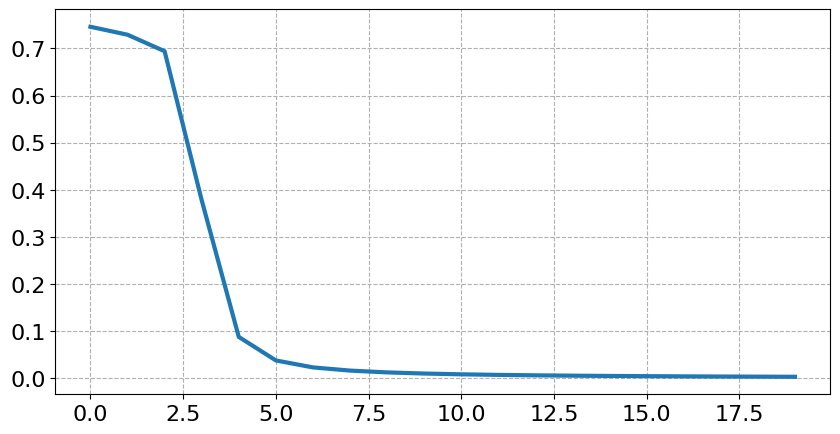

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(loss_values, linewidth=3)
plt.grid(True, linestyle='--')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()    

In [42]:
def evaluate(params, x_test, y_test):
    correct = 0
    total = len(y_test)
    for i in range(total):
        x = x_test[i]
        y_true = y_test[i]

        y_pred = forward(x, params)
        predicted_class = y_pred > 0.5

        if predicted_class == y_true.item():
            correct += 1
    acc = correct / total
    print(f"Test Accuracy: {acc * 100:.2f}%")
    
evaluate(params, X_test, y_test)

Test Accuracy: 100.00%
